# Reconstructing SIMIND Data

In [1]:
import os
import pytomography
from pytomography.io.SPECT import simind
from pytomography.metadata import PSFMeta
from pytomography.priors import RelativeDifferencePrior
from pytomography.projections import SystemMatrix
from pytomography.metadata import PSFMeta
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEMBSR
import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set the default device for all reconstruction for pytomography:

In [2]:
pytomography.device = device

Set the folder location for downloaded files (you will need to modify this to be the directory where you saved the files)

In [3]:
path = '/disk1/pytomography_tutorial_data/simind_tutorial/'

## Case 1: Single Projection File

When running SIMIND simulations, it is commonly the case that organs, background, and lesions are simulated seperately and then added together in projection space after the fact. For now, lets consider the case of a single SIMIND file containing all regions of the body, we'll move to seperate files later.

Open the object and image space metadata, along with the projection data:

In [4]:
object_meta, image_meta, projections = simind.get_projections(os.path.join(path, 'single_projections', 'body1t2ew6_tot_w2.hdr'))

Open the estimate for the scatter using the `get_scatter_from_TEW` method:

In [5]:
scatter = simind.get_scatter_from_TEW(
    headerfile_peak = os.path.join(path, 'single_projections', 'body1t2ew6_tot_w2.hdr'),
    headerfile_lower = os.path.join(path, 'single_projections', 'body1t2ew6_tot_w1.hdr'),
    headerfile_upper = os.path.join(path, 'single_projections', 'body1t2ew6_tot_w3.hdr')
)

The CT data is loaded in a similar fashion

In [6]:
CT = simind.get_atteuation_map(os.path.join(path, 'single_projections', 'body1.hct'))

It is good practice to ensure the CT and projections are aligned
* Note: the sagittal view of the CT is the mirror of the projection at 90 degrees; this has to do with the coordinate system defined in the manual.

In [7]:
CT_slice_coronal = CT[0,:,64,:].T.cpu()
projection_coronal = projections[0][0].T.cpu()
CT_slice_sagittal = CT[0,64,:,:].T.cpu()
projection_sagittal = projections[0][30].T.cpu()

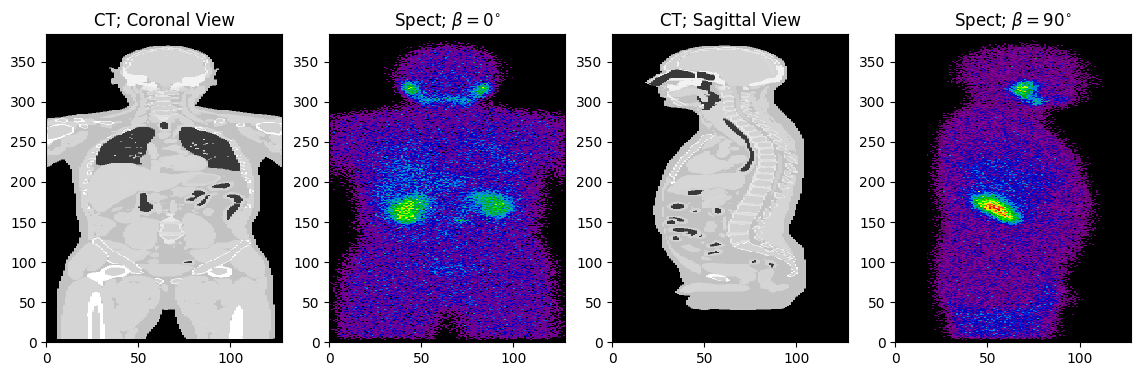

In [8]:
plt.subplots(1, 4, figsize=(14,4))
plt.subplot(141)
plt.pcolormesh(CT_slice_coronal, cmap='Greys_r')
plt.title('CT; Coronal View')
plt.subplot(142)
plt.pcolormesh(projection_coronal, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=0^{\circ}$')
plt.subplot(143)
plt.pcolormesh(CT_slice_sagittal, cmap='Greys_r')
plt.title('CT; Sagittal View')
plt.subplot(144)
plt.pcolormesh(projection_sagittal, cmap='nipy_spectral')
plt.title(r'Spect; $\beta=90^{\circ}$')
plt.show()

Now we need to define all the required mappings to model $g = Hf$

Attenuation Modeling

* This transform corresponds to a mapping $A_i(\theta)$ as specified in the user manual and takes in an object/corresponding projection angle and returns a modified object

In [9]:
att_transform = SPECTAttenuationTransform(CT)

PSF Modeling

* This transform corresponds to a mapping $A_i(\theta)$ as specified in the users manual. The PSF collimator information is obtained from the SIMIND header file

In [10]:
psf_meta = simind.get_psfmeta_from_header(os.path.join(path, 'single_projections', 'body1t2ew6_tot_w2.hdr'))
psf_transform = SPECTPSFTransform(psf_meta)

/home/gpuvmadm/PyTomography/src/pytomography/io/SPECT/helpers.py:43: RuntimeWarning: overflow encountered in exp
  return c1*np.exp(-d1*np.sqrt(energy)) + c2*np.exp(-d2*np.sqrt(energy))


Now we can build our system matrix $H$:

* The forward method `system_matrix.forward(f)` corresponds to $Hf$ where $H = \sum_{\theta} P(\theta)A_1(\theta)A_2(\theta) \otimes \hat{\theta}$
* The backward method `system_matrix.backward(g)` corresponds to $H^T g$ 

In [11]:
system_matrix = SystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    im2im_transforms = [],
    object_meta = object_meta,
    image_meta = image_meta)

We can also define the Bayesian Prior:

In [12]:
prior = RelativeDifferencePrior(beta=1, gamma=5)

The system matrix is then used to create the reconstruction algorithm, which in this case is a variant of OSEM using the block sequential regularizer technique to encorporate the prior defined above. Note that if the prior is not given, this reconstruction algorithm corresponds to regular OSEM.

In [13]:
reconstruction_algorithm = OSEMBSR(
    image = projections,
    system_matrix = system_matrix,
    scatter = scatter,
    prior = prior)

Get the reconstructed object

In [14]:
reconstructed_object = reconstruction_algorithm (n_iters=10, n_subsets=8)

Plot the reconstructed object next to the CT.
* The reconstructed object has units of counts, and would need to be adjusted by a proportionality factor if one wants to obtain units of MBq

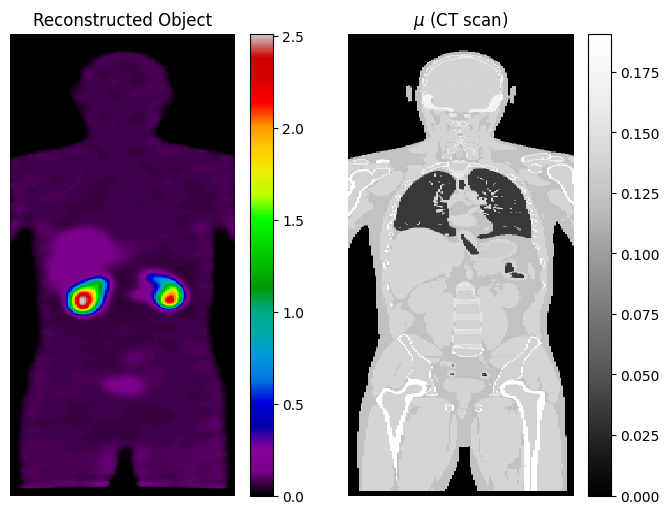

In [15]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(CT.cpu()[0][:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()

## Case 2: Multiple Projections

When running simulations with SIMIND, it is standard to run different regions of the body seperately and then combine them together in projection space after the fact. This enables one to create arbtrary organ activities using the same set of simulated data. A few noteworthy things

* SIMIND projection data is typically given in units of CPS/MBq where CPS=counts/second. Real life SPECT data consists of units of counts. In order to simulate a realistic scenario, therefor, we need to multiply the projections by some value in MBq, and some value in s. The value in MBq corresponds to the total activity of the organ/region you've simulated. The value in s corresponds to the total projection time.

We'll start by opening up SIMIND projections corresponding to 8 distinct regions of the body, each with activities representative of a true clinical case

In [16]:
organs = ['bkg', 'liver', 'l_lung', 'r_lung', 'l_kidney', 'r_kidney','salivary', 'bladder']
activities = [2500, 450, 7, 7, 100, 100, 20, 90] # MBq
headerfiles = [os.path.join(path, 'multi_projections', organ, 'photopeak.h00') for organ in organs]
headerfiles_lower = [os.path.join(path, 'multi_projections', organ, 'lowerscatter.h00') for organ in organs]
headerfiles_upper = [os.path.join(path, 'multi_projections', organ, 'upperscatter.h00') for organ in organs]

Open the projection/scatter data

In [17]:
object_meta, image_meta, projections = simind.combine_projection_data(headerfiles, activities)
scatter = simind.combine_scatter_data_TEW(headerfiles, headerfiles_lower, headerfiles_upper, activities)

Note that our `weights` were in units of MBq, so our projection data currently has units of counts/second.

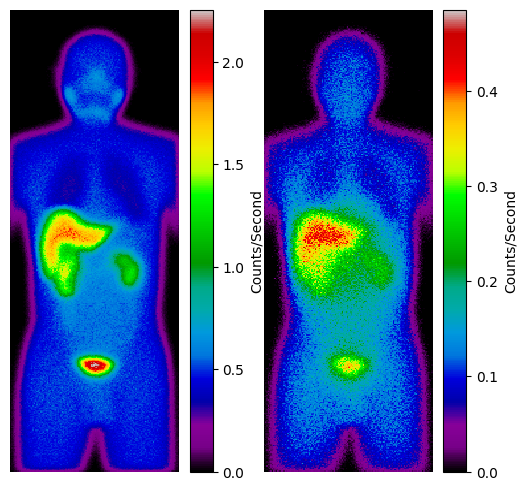

In [18]:
plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
plt.pcolormesh(projections[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts/Second')
plt.subplot(122)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts/Second')

Now we need to decide how long the scan was taken for. We'll assume each projection was taken for 15 seconds

In [19]:
dT = 15 #s
projections *= dT
scatter *= dT

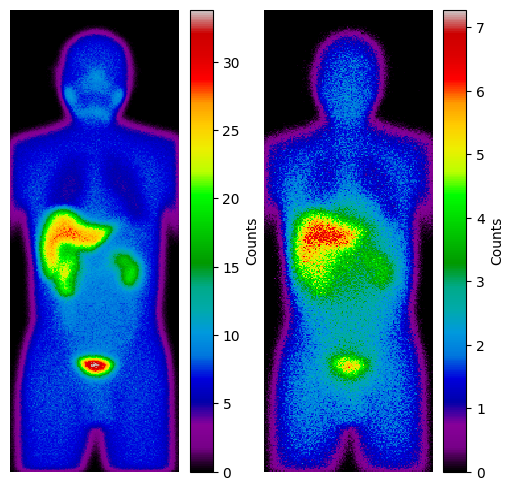

In [20]:
plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
plt.pcolormesh(projections[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')
plt.subplot(122)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')

In realtity, SPECT projection data is noisy. Provided enough events are ran during the SIMIND simulation, the SIMIND data is essentially noise-free. We need to add Poisson noise if we are to simulate a realistic clinical imaging scenario

In [21]:
projections = torch.poisson(projections)
scatter = torch.poisson(scatter)

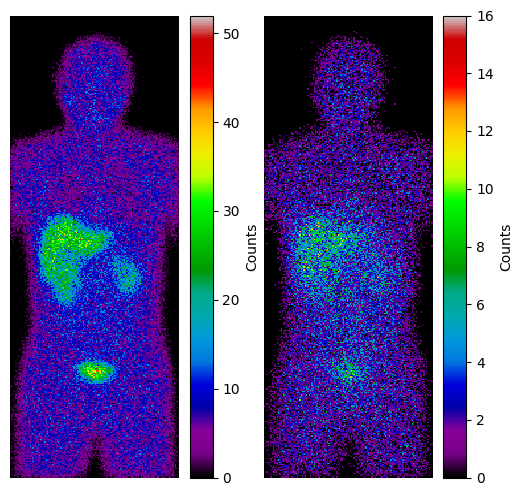

In [22]:
plt.subplots(1, 2, figsize=(6,6))
plt.subplot(121)
plt.pcolormesh(projections[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')
plt.subplot(122)
plt.pcolormesh(scatter[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')

Now the projection and scatter data is representative of a realistic clinical scenario. Now we reconstruct as we did earlier.

In [23]:
CT = simind.get_atteuation_map(os.path.join(path, 'multi_projections', 'mu208.hct'))
att_transform = SPECTAttenuationTransform(CT)
psf_meta = simind.get_psfmeta_from_header(headerfiles[0])
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    im2im_transforms = [],
    object_meta = object_meta,
    image_meta = image_meta)
prior = RelativeDifferencePrior(beta=1, gamma=5)
reconstruction_algorithm = OSEMBSR(
    image = projections,
    system_matrix = system_matrix,
    scatter = scatter,
    prior = prior)

In [24]:
reconstructed_object = reconstruction_algorithm(n_iters=10, n_subsets=8)

Lets see the reconstructed object

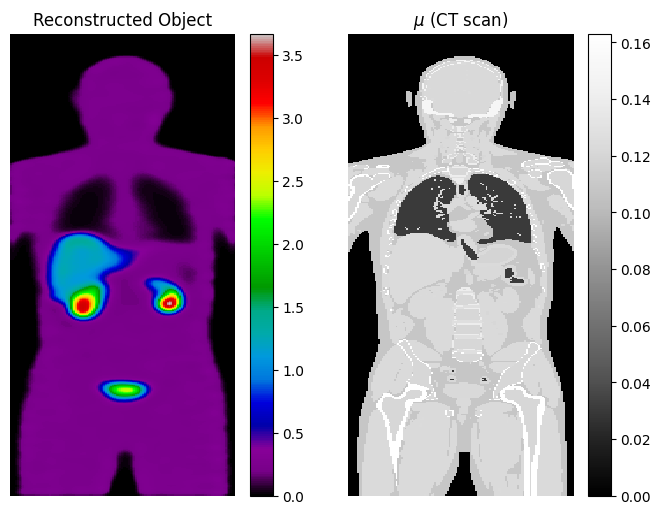

In [25]:
plt.subplots(1,2,figsize=(8,6))
plt.subplot(121)
plt.pcolormesh(reconstructed_object[0].cpu()[:,70].T, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('Reconstructed Object')
plt.subplot(122)
plt.pcolormesh(CT.cpu()[0][:,70].T, cmap='Greys_r')
plt.colorbar()
plt.axis('off')
plt.title('$\mu$ (CT scan)')
plt.show()